# Introduction

The notebook is intended to provide an example on how to train a Recurrent Neural Network with TensorFlow on real sales data.

In [1]:
# Import Standard Libraries
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Read Data

In [2]:
# Read data through Pandas
data = pd.read_csv('./../../data/RSCCASN.csv', index_col='DATE', parse_dates=True)

In [3]:
# Rename columns
data.columns = ['Sales']

In [4]:
data

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


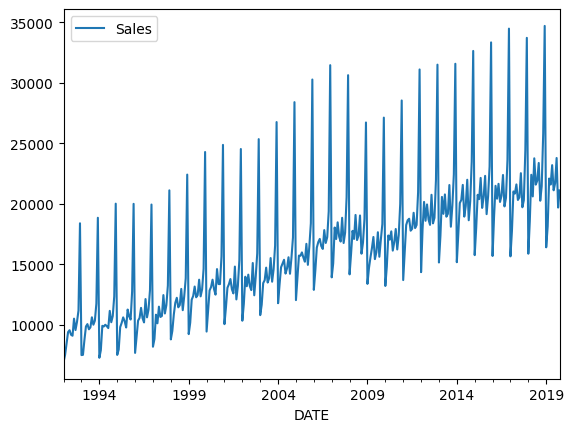

In [5]:
# Plot the data
data.plot()
plt.show()

# Train & Test Split

In [6]:
# Define test size in months
test_size = 18

# Compute the start index of the test set
test_index = len(data) - test_size

In [7]:
# Split
train_data = data.iloc[:test_index]
test_data = data.iloc[test_index:]

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1992-01-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   316 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


# Data Preparation

## Standardization

In [9]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(train_data)

# Transform the data
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

## Batch Generator

In [10]:
# Define number of time steps in the input and the batch size
input_steps = 12
batch_size = 1

In [11]:
# Define the batch generator
batch_generator = TimeseriesGenerator(train_data_scaled,
                                      train_data_scaled,
                                      length=input_steps,
                                      batch_size=batch_size)

In [12]:
# Create a validation generator for the Early Stopping
validation_batch_generator = TimeseriesGenerator(test_data_scaled, 
                                                 test_data_scaled, 
                                                 length=input_steps, 
                                                 batch_size=1)

# Modeling

## LSTM

### Architecture

In [13]:
# Define the model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(input_steps, 1)),
    Dense(1)
])

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Define early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

### Training

In [17]:
# Fit through the batch_generator
model.fit(batch_generator, 
          epochs=20, 
          validation_data=validation_batch_generator, 
          callbacks=[early_stopping_callback])

Epoch 1/20
304/304 [==============================] - 2s 4ms/step - loss: 0.0255 - val_loss: 0.0040
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0454
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0099


### Model Evaluation

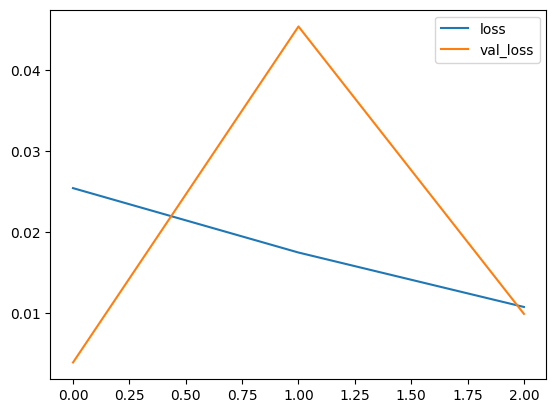

In [18]:
# Plot loss
pd.DataFrame(model.history.history).plot()
plt.show()

In [19]:
# Initialise the prediciton for the test set
test_predictions = []

# Set the first evaluation batch
current_batch = train_data_scaled[-input_steps:].reshape((1, input_steps, 1))

# Loop though all the test set
for index in range(len(test_data_scaled)):

    # Predict
    prediction = model.predict(current_batch)[0]

    # Append the current prediction
    test_predictions.append(prediction)

    # Rolling forward
    current_batch = np.append(current_batch[:,1:,:],
                              [[prediction]], 
                              axis=1)

1/1 [==============================] - 0s 15ms/step


In [23]:
# Scale back test predictions
test_unscaled_predictions = scaler.inverse_transform(test_predictions)

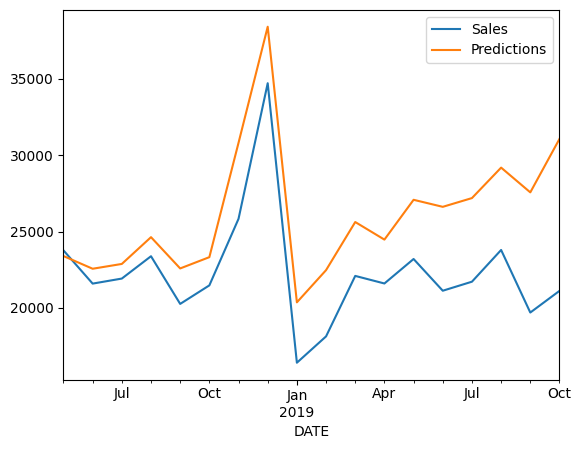

In [31]:
# Plot predictions vs true sequence
test_data.loc[:, 'Predictions'] = test_unscaled_predictions

test_data.plot()

plt.show()